In [2]:
import pyvista as pv
import numpy as np
from typing import Any, Tuple
from importlib import reload
import multiprocessing
import ifcopenshell
import ifcopenshell.geom
import time
from functools import reduce
import open3d as o3d
import random
import glob
import os
import pandas as pd
from collections import defaultdict
import datetime
from csv import writer
import traceback

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def random_color():
    """Generate a random RGB color."""
    return [random.random(), random.random(), random.random()]

def open3d_block_by_element(ifc_file): 
    # Configuration for ifcopenshell geometric settings
    settings = ifcopenshell.geom.settings()
    settings.set(settings.USE_WORLD_COORDS, True)
    settings.set(settings.APPLY_DEFAULT_MATERIALS, True)

    # Initialize the iterator for geometric representations
    iterator = ifcopenshell.geom.iterator(settings, ifc_file, multiprocessing.cpu_count())
    
    # Define entity types to include and exclude
    exclude_list = set(["IfcCovering", "IfcFurnishingElement", "IfcSpace", "IfcOpening", "IfcOpeningElement", "IfcRailing"])
    
    # Lists to store the resulting meshes and element information
    all_meshes = []
    element_information = {}
    
    # Variable to track the smallest dimension among all meshes
    temp_dimension_x = 5.0
    temp_dimension_y = 5.0
    temp_dimension_z = 5.0
    max_dimension = 0
    # Iterate over the geometric representations
    if iterator.initialize():
        index = 0
        while True:
            shape = iterator.get()
            
            # Check if the shape type is not excluded and represents an IfcBuildingElement
            if shape.type not in exclude_list and shape.product.is_a("IfcBuildingElement"):
                # Convert the shape's geometry to an Open3D mesh
                faces = np.array(shape.geometry.faces)
                verts = np.array(shape.geometry.verts).reshape(-1, 3)
                mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(verts),
                                                 triangles=o3d.utility.Vector3iVector(faces.reshape(-1, 3)))
                
                # Update the smallest dimension if necessary
                dimensions = mesh.get_max_bound() - mesh.get_min_bound()
                min_dimension_x, min_dimension_y, min_dimension_z = dimensions

                # Update temp_dimension_x, temp_dimension_y, temp_dimension_z if necessary
                if min(temp_dimension_x, min_dimension_x) >= 0.1:
                    temp_dimension_x = min(temp_dimension_x, min_dimension_x)
                if min(temp_dimension_y, min_dimension_y) >= 0.1:
                    temp_dimension_y = min(temp_dimension_y, min_dimension_y)
                

                # Store the mesh and its corresponding IFC GUID
                all_meshes.append(mesh)
                element_information[index] = shape.guid
                index += 1
                
                # Check if the shape is a slab and update the maximum x dimension if necessary
                if shape.type == "IfcSlab":
                    if min(temp_dimension_z, min_dimension_z) >= 0.1:
                        temp_dimension_z = min(temp_dimension_z, min_dimension_z)
                    y_dimension = abs(mesh.get_max_bound()[1] - mesh.get_min_bound()[1])
                    x_dimension = abs(mesh.get_max_bound()[0] - mesh.get_min_bound()[0])
                    # Find the biggest dimension between x and y
                    biggest_dimension = max(x_dimension, y_dimension)
                    
                    if biggest_dimension > max_dimension:  # Assuming max_dimension is defined and initialized to 0
                        max_dimension = biggest_dimension
                        guide_shape = mesh
                       
                    
            # Move to the next geometric representation
            if not iterator.next():
                
                break

    return all_meshes, element_information, temp_dimension_x, temp_dimension_y, temp_dimension_z, guide_shape

def create_uniform_grid(bounds, voxel_size_x, voxel_size_y, voxel_size_z):
    """Create a uniform grid within the given bounds with rectangular cells."""
    x = np.arange(bounds[0], bounds[1] + voxel_size_x, voxel_size_x)
    y = np.arange(bounds[2], bounds[3] + voxel_size_y, voxel_size_y)
    z = np.arange(bounds[4], bounds[5] + voxel_size_z, voxel_size_z)
    return pv.StructuredGrid(*np.meshgrid(x, y, z))


def open3d_to_pyvista(point_cloud_o3d):
    """
    Convert an Open3D point cloud to a PyVista point cloud.

    Parameters:
    - point_cloud_o3d: The Open3D point cloud.

    Returns:
    - A PyVista `PolyData` object.
    """
    # Extract points from Open3D point cloud
    points = np.asarray(point_cloud_o3d.points)

    # Create a PyVista PolyData object
    point_cloud_pv = pv.PolyData(points)

    return point_cloud_pv

def process_point(pcd, mesh_guid_index, grid_bounds, temp_dimension_x, temp_dimension_y, temp_dimension_z, dims, grid_attributes):
    j = int((pcd[0] - grid_bounds[0]) / temp_dimension_x)
    i = int((pcd[1] - grid_bounds[2]) / temp_dimension_y)
    k = int((pcd[2] - grid_bounds[4]) / temp_dimension_z)
    
    if 0 <= i < dims[0]-1 and 0 <= j < dims[1]-1 and 0 <= k < dims[2]-1 and grid_attributes[i,j,k] == -1:
        grid_attributes[i,j,k] = mesh_guid_index

def voxelize_space(bounds, pcd_list, temp_dimension_x, temp_dimension_y, temp_dimension_z):
    """Create a 3d grid and check the intersections of the meshes with the grid."""
    grid = create_uniform_grid(bounds, temp_dimension_x, temp_dimension_y, temp_dimension_z)
    
    # create an empty 3d array in the same dimensions of the grid
    dims = grid.dimensions
    grid_attributes = np.full((dims[0]-1, dims[1]-1, dims[2]-1), -1, dtype=int)

    grid_bounds = grid.bounds
    
    [process_point(point, i, grid_bounds, temp_dimension_x, temp_dimension_y, temp_dimension_z, dims, grid_attributes) 
    for i, pcd in enumerate(pcd_list) for point in pcd.points]

    # assign empty array to the grid
    grid.cell_data['attributes'] = grid_attributes.flatten(order='F').astype(int)
    
    return grid

def get_sampling_points(mesh, voxel_size, points_per_unit_area=120):
    
    # Calculate the surface area of the mesh
    area = mesh.get_surface_area()

    # Calculate the number of points to sample
    N = int(area * points_per_unit_area*1/voxel_size)
        
    return N

def create_point_cloud(all_meshes, temp_dimension_x, temp_dimension_y, temp_dimension_z):
    """Create a point cloud from a mesh."""

    pcd_list = []

    for mesh in all_meshes:
        # Get the number of points to sample based on the mesh size
        N = get_sampling_points(mesh, temp_dimension_x)
        pcd = mesh.sample_points_uniformly(N)
        pcd_pv = open3d_to_pyvista(pcd)
        pcd_list.append(pcd_pv)  
        
    return pcd_list

def fetch_element_quantities(ifc_file, grid, temp_dimension_x, temp_dimension_y, temp_dimension_z, element_information):
    # Fetch all property sets named 'ZECH_ATTRIBUTE'
    property_sets = ifc_file.by_type("IfcPropertySet")
    zech_property_sets = [ps for ps in property_sets if ps.Name == "ZECH_ATTRIBUTE"]
    
    # Create a mapping of elements to their ZB_AUSWAHL values
    element_to_zb_auswahl = {}
    for ps in zech_property_sets:
        for prop in ps.HasProperties:
            if prop.is_a("IfcPropertySingleValue") and prop.Name == "ZB_AUSWAHL":
                # Find all elements that have this property set
                for rel in ifc_file.by_type("IfcRelDefinesByProperties"):
                    if rel.RelatingPropertyDefinition == ps:
                        for related_object in rel.RelatedObjects:
                            element_to_zb_auswahl[related_object.GlobalId] = str(prop.NominalValue.wrappedValue)
    
    element_volumes = defaultdict(int)
    
    # Calculate volumes
    for att in grid.cell_data['attributes']:
        element_guid = element_information.get(att)
        zb_auswahl_value = element_to_zb_auswahl.get(element_guid)
        if zb_auswahl_value is not None:
            element_volumes[zb_auswahl_value] += 1
    
    # Convert counts to volumes
    for zb_auswahl_value, count in element_volumes.items():
        element_volumes[zb_auswahl_value] = round(count * temp_dimension_x*temp_dimension_y*temp_dimension_z, 3)
    
    return element_volumes

def get_axis(p0, p1):
    """Get normalized axis vector from point p0 to p1."""
    axis = np.array(p1) - np.array(p0)
    return axis / np.linalg.norm(axis)

def rotate_vector(vector, angle_degrees):
    """Rotate a 3D vector by a specified angle around the Z-axis."""
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians), 0],
        [np.sin(angle_radians), np.cos(angle_radians), 0],
        [0, 0, 1]
    ])
    return np.dot(rotation_matrix, vector)

def rotate_meshes(all_meshes, guide_shape):
    ### TODO: Find the difference of angle between axis aligned box and an object
    # combine all meshes into one mesh and find the bounds
    obb = guide_shape.get_oriented_bounding_box()
    obb_points_o3d = np.asarray(obb.get_box_points())
    
    # Extract points from Open3D point cloud
    maxZ = np.max(obb_points_o3d[:, 2])  # maximum Z coord
    
    obb_pts = []
    for point in obb_points_o3d:
        # Change Z to minZ or maxZ depending on its proximity
        obb_pts.append((point[0], point[1], maxZ))
    
    # Find two points with the biggest x difference
    points_for_axis1 = (obb_pts[0], obb_pts[1])  # Initialize with first two points
    
    # Get the axes of the OBB
    axis1 = get_axis(*points_for_axis1)
    axis2 = rotate_vector(axis1, 90)
    axis3 = (0,0,1)
    
    # Construct the rotation matrix
    R = np.vstack((axis1, axis2, axis3)).T
   
    axis3_prime = np.cross(axis1, axis2)

    # Check whether axis3' and axis3 are pointing in the same direction
    if np.dot(axis3_prime, axis3) < 0:
        # If not, swap axis1 and axis2 to get a right-handed system
        axis1, axis2 = axis2, axis1

        # Reconstruct the rotation matrix
        R = np.vstack((axis1, axis2, axis3)).T

    # Validate the rotation matrix
    assert np.allclose(np.dot(R.T, R), np.eye(3)), "Rotation matrix is not orthogonal!"
    assert np.isclose(np.linalg.det(R), 1, atol=1e-8), "Determinant of rotation matrix is not 1!"
    
    rotated_meshes = []
    
    for mesh in all_meshes:
        # Get the vertices of the mesh
        vertices = np.asarray(mesh.vertices)
        
        # Apply the rotation
        rotated_vertices = vertices.dot(R.T)
        
        # Update the mesh vertices
        mesh.vertices = o3d.utility.Vector3dVector(rotated_vertices)
        rotated_meshes.append(mesh)
    
    vertices2 = np.asarray(obb_points_o3d)
    rotated_vertices2 = vertices2.dot(R.T)
    

    return rotated_meshes, rotated_vertices2

def process_ifc_file(file_name, writer):
    try:
        pv.set_plot_theme("document")
        pv.global_theme.jupyter_backend = 'static'
        p = pv.Plotter()

        ifc_file = ifcopenshell.open(file_name)
        print(file_name)

        ### CONVERSION FROM IFC TO MESH ###
        print(f'Converting {file_name}...')

        start_time = time.time()
        all_meshes, element_information, temp_dimension_x, temp_dimension_y, temp_dimension_z, guide_shape = open3d_block_by_element(ifc_file)
        total_polygons = sum(len(mesh.triangles) for mesh in all_meshes)

        rotated_meshes, rotated_obb_pts = rotate_meshes(all_meshes, guide_shape)
        # Extract points from Open3D point cloud
        points = np.asarray(rotated_obb_pts)

        # Create a PyVista PolyData object
        point_cloud_pv = pv.PolyData(points)

        p.add_mesh(point_cloud_pv.points, color="red", point_size=20)

        combined_mesh= reduce(lambda m1, m2: m1 + m2, rotated_meshes)
        end_time = time.time()
        conversion_time = end_time - start_time

        ### POINT CLOUD CREATION ###
        print(f'Point cloud formation representing {file_name}...')
        start_time = time.time()
        point_cloud_list  = create_point_cloud(rotated_meshes, temp_dimension_x, temp_dimension_y, temp_dimension_z)
        
        #merge all the list of point clouds into one
        pcd_pv = pv.PolyData()
        pcd_pv.points = np.vstack(list(map(lambda x: x.points, point_cloud_list)))
        sampling_points = len(pcd_pv.points)
        end_time = time.time()
        point_cloud_processing = end_time - start_time

        print(f'Rasterizing {file_name}...')
        start_time = time.time()

        # Compute the oriented bounding box (OBB)
        bb = combined_mesh.get_axis_aligned_bounding_box()
        
        # Extract the eight corner points of the OBB
        bb_points = np.asarray(bb.get_box_points())

        # Compute the axis-aligned bounding box of these eight points
        xmin, ymin, zmin = np.min(bb_points, axis=0)
        xmax, ymax, zmax = np.max(bb_points, axis=0)

        bounds = np.array([xmin, xmax, ymin, ymax, zmin, zmax])
        
        ### RASTERIZATION ###
        
        grid = voxelize_space(bounds, point_cloud_list, temp_dimension_x, temp_dimension_y, temp_dimension_z)
        end_time = time.time()
        rasterization_time = end_time - start_time

        ### VISUALIZATION ###
        print(f'Visualizing {file_name}...')
        start_time = time.time()
         
        # Extract the cells with non-empty attribute values
        non_empty_cells = grid.cell_data['attributes'] != -1  

        # Create a box from the bounds
        box = pv.Box(bounds=bounds)

        # Add the box to the plotter
        p.add_mesh(box, color="blue", style="wireframe", line_width=2)

        # Add the mesh to the plotter with the non-empty cells
        p.add_mesh(grid.extract_cells(non_empty_cells), opacity=0.5, show_edges=False,show_scalar_bar=False)
        
        screenshot_filename = os.path.join("screenshots", os.path.basename(file_name) + ".png")
        p.screenshot(screenshot_filename)

        end_time = time.time()
        visualization_time = end_time - start_time
        p.show()

         # Store the results in a dictionary
        results = {}
        results['File'] = file_name
        results['# of Polygons'] = total_polygons
        results['# of Points'] = sampling_points
        results['Cell Size (m)'] = temp_dimension_x, temp_dimension_y, temp_dimension_z
        results['Conversion (sec)'] = round(conversion_time,2)
        results['Point Cloud Creation (sec)'] = round(point_cloud_processing,2)
        results['Rasterization (sec)'] = round(rasterization_time,2)
        results['Visualization (sec)'] = round(visualization_time,2)
    
        print(f'Calculating quantities in {file_name}...')
        
        start_time = time.time()
        element_volumes = fetch_element_quantities(ifc_file, grid, temp_dimension_x, temp_dimension_y, temp_dimension_z, element_information)

        results_QTO = {}

        # Store the concrete volumes for different ZB_AUSWAHL values
        for zb_auswahl_value, volume in element_volumes.items():
            results_QTO[f'{zb_auswahl_value}'] = volume

        end_time = time.time()
        quantity_calculation_time = end_time - start_time
        results['Quantity Calculation (sec)'] = quantity_calculation_time

        print(results)
        print(results_QTO)

        # Write results to Excel
        df_results = pd.DataFrame([results])
        df_results_QTO = pd.DataFrame([results_QTO])
        df_results_QTO = df_results_QTO

        # Find the last row in the Excel sheets
        last_row_results = writer.sheets['Results'].max_row
        last_row_qto = writer.sheets['QTO'].max_row

        # Write the dataframes to Excel, starting at the last row
        df_results.to_excel(writer, sheet_name='Results', startrow=last_row_results, index=False, header=False)
        df_results_QTO.T.to_excel(writer, sheet_name='QTO', startrow=last_row_qto, header=True)
        screenshot_filename = os.path.join("screenshots", os.path.basename(file_name) + ".png")
        p.screenshot(screenshot_filename)

        # Ensure that the writer object is returned'''
        return writer

    except FileNotFoundError:
        print(f"Error: {file_name} not found.")
        print("Here's the traceback:")
        traceback.print_exc()
        return {}, {}

    except MemoryError:
        print(f"Error: Insufficient memory to process {file_name}.")
        print("Here's the traceback:")
        traceback.print_exc()
        return {}, {}

    except (TypeError, ValueError) as e:
        print(f"Error processing {file_name}: {str(e)}")
        print("Here's the traceback:")
        traceback.print_exc()
        return {}, {}

    except Exception as e:
        print(f"An unexpected error occurred while processing {file_name}: {str(e)}")
        print("Here's the traceback:")
        traceback.print_exc()
        return {}, {}
    
def find_ifc_files(directory):
    """Find all IFC files in a given directory."""
    # Use os.path.join to ensure the path is constructed correctly for any OS
    search_path = os.path.join(directory, "*.ifc")
    return glob.glob(search_path)

IFC Files/04.ifc
Converting IFC Files/04.ifc...
Point cloud formation representing IFC Files/04.ifc...
Rasterizing IFC Files/04.ifc...
Visualizing IFC Files/04.ifc...


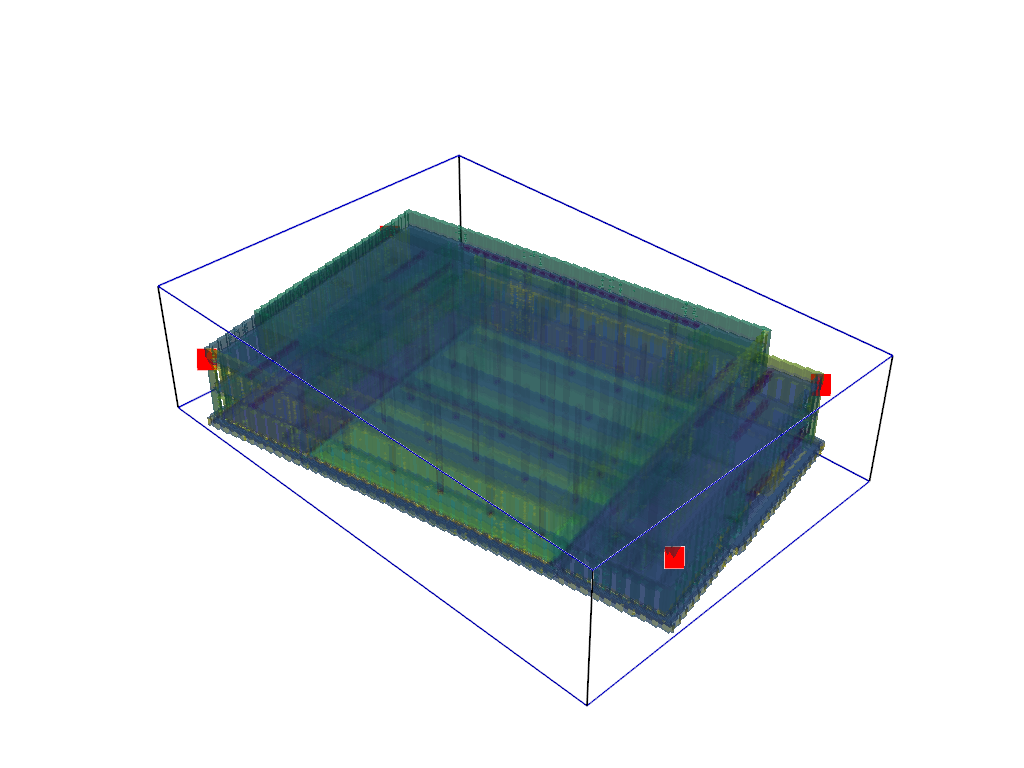

Calculating quantities in IFC Files/04.ifc...
{'File': 'IFC Files/04.ifc', '# of Polygons': 16440, '# of Points': 17964253, 'Cell Size (m)': (0.2937960762228613, 0.30033600417664275, 0.10000000000000853), 'Conversion (sec)': 2.25, 'Point Cloud Creation (sec)': 2.76, 'Rasterization (sec)': 76.5, 'Visualization (sec)': 1.14, 'Quantity Calculation (sec)': 2.367736577987671}
{'ZB_STR_FUN': 545.811, 'ZB_P_FUN': 33.08, 'ZB_UNTF': 10.941, 'ZB_SOHLE': 589.806, 'ZB_PERI_BO': 221.644, 'ZB_RECK_ST': 213.464, 'ZB_PERI_W': 49.316, 'ZB_ORT_W': 2263.311, 'ZB_KS_MW': 777.505, 'ZB_FT_TRH': 36.786, 'ZB_ORT_POD': 15.442, 'ZB_ORT_DECKE': 1390.677, 'ZB_STB_UZ': 85.97, 'ZB_STB_ATT': 376.271}


In [4]:
'''# Get the current date and time
now = datetime.datetime.now()

# Format the date and time as a string: YYYYMMDD_HHMMSS
formatted_time = now.strftime("%Y_%m_%d")

# Create a filename using the formatted time
filename = f"output_{formatted_time}.xlsx"

# Ensure the writer context is used when calling process_ifc_file
with pd.ExcelWriter(filename, engine='openpyxl') as writer:
    
    # Create initial empty DataFrames to set up the Excel sheets
    pd.DataFrame(columns=['File', '# of Polygons', '# of Points', 'Cell Size (m)', 'Conversion Time (sec)', 'Point Cloud Creation Time (sec)', 'Rasterization (sec)', 'Visualization (sec)', 'Concrete Calculation Time (sec)']).to_excel(writer, sheet_name='Results')
    pd.DataFrame().to_excel(writer, sheet_name='QTO')  # Add appropriate columns if needed
    
    # Call process_ifc_file within the writer context
    process_ifc_file("IFC Files/04.ifc", writer)'''

In [5]:
directory_path = "IFC Files/"
ifc_files = find_ifc_files(directory_path)

# Get the current date and time
now = datetime.datetime.now()

# Format the date and time as a string: YYYYMMDD_HHMMSS
formatted_time = now.strftime("%Y%m%d")

# Create a filename using the formatted time
filename = f"output_{formatted_time}_rotated_affine.xlsx"

# Create an Excel writer object
# Ensure the writer context is used when calling process_ifc_file
with pd.ExcelWriter(filename, engine='openpyxl') as writer:
    # Create initial empty DataFrames to set up the Excel sheets
    pd.DataFrame(columns=['File', '# of Polygons', '# of Points', 'Cell Size (m)', 'Conversion Time (sec)', 'Point Cloud Creation Time (sec)', 'Rasterization (sec)', 'Visualization (sec)', 'Concrete Calculation Time (sec)']).to_excel(writer, sheet_name='Results')
    pd.DataFrame().to_excel(writer, sheet_name='QTO')  # Add appropriate columns if needed
      
    # Process each IFC file and write the results to Excel
    for file_name in ifc_files:
        process_ifc_file(file_name, writer)


'directory_path = "IFC Files/"\nifc_files = find_ifc_files(directory_path)\n\n# Get the current date and time\nnow = datetime.datetime.now()\n\n# Format the date and time as a string: YYYYMMDD_HHMMSS\nformatted_time = now.strftime("%Y%m%d_%H%M%S")\n\n# Create a filename using the formatted time\nfilename = f"output_{formatted_time}.xlsx"\n\n# Create an Excel writer object\n# Ensure the writer context is used when calling process_ifc_file\nwith pd.ExcelWriter(filename, engine=\'openpyxl\') as writer:\n    # Create initial empty DataFrames to set up the Excel sheets\n    pd.DataFrame(columns=[\'File\', \'# of Polygons\', \'# of Points\', \'Cell Size (m)\', \'Conversion Time (sec)\', \'Point Cloud Creation Time (sec)\', \'Rasterization (sec)\', \'Visualization (sec)\', \'Concrete Calculation Time (sec)\']).to_excel(writer, sheet_name=\'Results\')\n    pd.DataFrame().to_excel(writer, sheet_name=\'QTO\')  # Add appropriate columns if needed\n      \n    # Process each IFC file and write the